# 0. Importing libraries, mergning raw files, exporting merged "master file" and reading it in for cleaning


In [16]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
import pyarrow.parquet as pq
import os
import glob
from pathlib import Path

In [17]:


input_path = Path('/Users/victor/School/sem6/bachelor/scraping/file3.csv')
df = pd.read_csv(input_path, low_memory=False)


In [18]:
# importing masterfile as df



In [19]:
df.info()

# as seen memory usage is large. we'll work on that during the cleaning and finetuning

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48300 entries, 0 to 48299
Data columns (total 8 columns):
 #   Column                                                               Non-Null Count  Dtype 
---  ------                                                               --------------  ----- 
 0   Boligtype & Adresse                                                  48300 non-null  object
 1   Købesum                                                              48300 non-null  object
 2   Dato & Type                                                          48300 non-null  object
 3   m² & Kr. / m²                                                        48300 non-null  object
 4   Vær.                                                                 48300 non-null  int64 
 5   Byggeår                                                              48300 non-null  int64 
 6   Den procentuelle forskel mellem seneste udbudspris og salgsprisen %  27164 non-null  object
 7   Unnamed: 7    

# 1. Investigating data

In [20]:
# we'll have a look at the df to get a sense of the data

df.head(3)

,Boligtype & Adresse,Købesum,Dato & Type,m² & Kr. / m²,Vær.,Byggeår,Den procentuelle forskel mellem seneste udbudspris og salgsprisen %,Unnamed: 7
0,Villa VVilla Nordlundsvej 43 2650 Hvidovre,6.375.000 kr.,28-05-2025Alm. Salg,180 m² 35.417 kr/m²,6,1954,-2%,Aktuel værdi
1,"Fritidshus FFritidshus Vikærparken 67, Diernæs...",1.200.000 kr.,28-05-2025Fam. Salg,74 m² 16.216 kr/m²,4,1993,NaN,Aktuel værdi
2,"Rækkehus RRækkehus Vinterslevvej 53C, Vintersl...",2.775.000 kr.,28-05-2025Alm. Salg,112 m² 24.777 kr/m²,3,2022,NaN,Aktuel værdi


In [21]:
# checking shape

df.shape

(48300, 8)

In [22]:
# checking duplicates (will revert on this later)

df[df.duplicated(['Boligtype & Adresse'], keep=False)]

,Boligtype & Adresse,Købesum,Dato & Type,m² & Kr. / m²,Vær.,Byggeår,Den procentuelle forskel mellem seneste udbudspris og salgsprisen %,Unnamed: 7
11517,Fritidshus FFritidshus Ingeborgvej 2 9480 Løkken,980.000 kr.,12-03-2025Alm. Salg,100 m² 9.800 kr/m²,4,1978,-2%,Aktuel værdi
20723,Fritidshus FFritidshus Ingeborgvej 2 9480 Løkken,715.000 kr.,05-02-2025Alm. Salg,100 m² 7.150 kr/m²,4,1978,-4%,Aktuel værdi
37960,Fritidshus FFritidshus Ingeborgvej 2 9480 Løkken,815.000 kr.,28-11-2024Alm. Salg,100 m² 8.150 kr/m²,4,1978,-1%,Aktuel værdi
43375,Fritidshus FFritidshus Ingeborgvej 2 9480 Løkken,900.000 kr.,11-11-2024Alm. Salg,100 m² 9.000 kr/m²,4,1978,-5%,Aktuel værdi


In [23]:
# checking dtypes()

df.dtypes

Boligtype & Adresse                                                    object
Købesum                                                                object
Dato & Type                                                            object
m² & Kr. / m²                                                          object
Vær.                                                                    int64
Byggeår                                                                 int64
Den procentuelle forskel mellem seneste udbudspris og salgsprisen %    object
Unnamed: 7                                                             object
dtype: object

In [24]:
# checking for na's

df.isnull().sum()

# as seen we have quite a few na's due to "double" columns

Boligtype & Adresse                                                        0
Købesum                                                                    0
Dato & Type                                                                0
m² & Kr. / m²                                                              0
Vær.                                                                       0
Byggeår                                                                    0
Den procentuelle forskel mellem seneste udbudspris og salgsprisen %    21136
Unnamed: 7                                                                 0
dtype: int64

In [27]:
# creating 4 new columns by combining "double" columns

df['purchase_price'] = df['Købesum']
df['sqm'] = df['m² & Kr. / m²']
df['no_rooms'] = df['Vær.']
df['year_build'] = df['Byggeår']

In [31]:
# dropping 8 columns as we have created the new 4 columns. dropping "Unnamed: 7" as well as it does not have any numerical value we can use

df = df.drop([ 'Byggeår', 'Unnamed: 7'], axis=1)

In [32]:
# renaming columns (Danish to English)

df.rename(columns = {"Boligtype & Adresse" : "type_and_address" , 
                      'Dato & Type' : 'date_and_sales_type' ,                    
                      "Den procentuelle forskel mellem seneste udbudspris og salgsprisen %" : "%_change_between_offer_and_purchase"}, inplace=True)

In [34]:
# checking df

df.head(3)

,type_and_address,Købesum,date_and_sales_type,m² & Kr. / m²,Vær.,%_change_between_offer_and_purchase,purchase_price,sqm,no_rooms,year_build
0,Villa VVilla Nordlundsvej 43 2650 Hvidovre,6.375.000 kr.,28-05-2025Alm. Salg,180 m² 35.417 kr/m²,6,-2%,6.375.000 kr.,180 m² 35.417 kr/m²,6,1954
1,"Fritidshus FFritidshus Vikærparken 67, Diernæs...",1.200.000 kr.,28-05-2025Fam. Salg,74 m² 16.216 kr/m²,4,NaN,1.200.000 kr.,74 m² 16.216 kr/m²,4,1993
2,"Rækkehus RRækkehus Vinterslevvej 53C, Vintersl...",2.775.000 kr.,28-05-2025Alm. Salg,112 m² 24.777 kr/m²,3,NaN,2.775.000 kr.,112 m² 24.777 kr/m²,3,2022


In [35]:
# # checking for na's again. there's only nans in "%_change_between_offer_and_purchase". we'll get back to that

df.isnull().sum()

type_and_address                           0
Købesum                                    0
date_and_sales_type                        0
m² & Kr. / m²                              0
Vær.                                       0
%_change_between_offer_and_purchase    21136
purchase_price                             0
sqm                                        0
no_rooms                                   0
year_build                                 0
dtype: int64

# 2. Split data and cleaning colums (date_and_sales_type column)

In [36]:
# we'll start by creating a seperate date column

df["date"] = df["date_and_sales_type"].str[0:10]

In [37]:
# convert dtype of new "date" column from object to datetime

df["date"] = pd.to_datetime(df["date"], dayfirst=False)

/var/folders/qr/zdl1jn496pg73658gxs99sxh0000gn/T/ipykernel_23337/269418460.py:3: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["date"] = pd.to_datetime(df["date"], dayfirst=False)


In [38]:
# we'll create a seperate sales_type column

df["sales_type"] = df["date_and_sales_type"].str[10:]

In [39]:
# checking unique string types in "sales_type"

df["sales_type"].unique()

array(['Alm. Salg', 'Fam. Salg', 'Andet'], dtype=object)

In [40]:
# converting unique string types in "sales_type" from Danish to English

df["sales_type"] = df["sales_type"].str.replace("Alm. Salg" , "regular_sale")
df["sales_type"] = df["sales_type"].str.replace("Fam. Salg" , "family_sale")
df["sales_type"] = df["sales_type"].str.replace("Andet" , "other_sale")
df["sales_type"] = df["sales_type"].str.replace("Auktion" , "auction")

In [41]:
# check convert unique string types in "sales_type"

df["sales_type"].unique()

array(['regular_sale', 'family_sale', 'other_sale'], dtype=object)

In [42]:
# changing dtype of "sales_type" column from object to category to reduce memory usage

df["sales_type"] = df["sales_type"].astype("category")

In [43]:
# show number of different sale_types

df["sales_type"].value_counts()

sales_type
regular_sale    43570
family_sale      3023
other_sale       1707
Name: count, dtype: int64

In [44]:
# dropping "date_and_sales_type" column as we have created the 2 new columns

df = df.drop("date_and_sales_type", axis=1)

# we are done with the orginal "date_and_sales_type" and we now have two seperate columns

# 3. Split data and cleaning colums (purchase_price column)

In [ ]:
# deleting ".kr" and "." in column purchase_price as we want to convert the column to a numeric column

df["purchase_price"] = df["purchase_price"].str.replace("kr." , "")
df["purchase_price"] = df["purchase_price"].str.replace("." , "")
df["purchase_price"] = df["purchase_price"].str.strip()   # strips white space

In [46]:
# converting to numeric and setting int to int32 to save memory

df["purchase_price"] = pd.to_numeric(df["purchase_price"].astype(np.int32))

# we are done with the "purchase_price" column

In [47]:
df["purchase_price"]

0        6375000
1        1200000
2        2775000
3         900000
4        1100000
          ...   
48295    2300000
48296     450000
48297    2495000
48298    7550000
48299    2130000
Name: purchase_price, Length: 48300, dtype: int32

<Axes: >

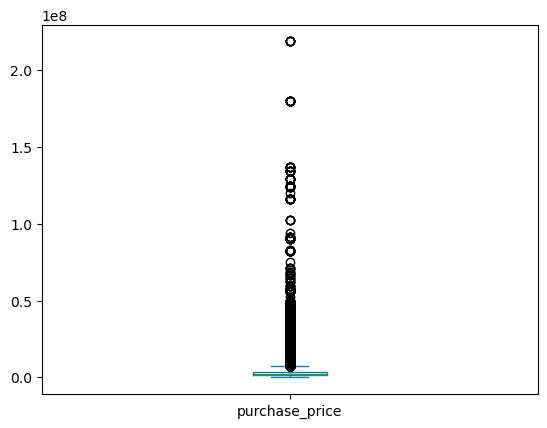

In [48]:
# checking for outlines in purchase_price

df["purchase_price"].plot(kind="box")

# as seen we have a some extreme purchase_prices

In [49]:
# checking purchase_price greater than DKK 50,000,000 as these most likely are incorrect

df[df["purchase_price"] > 50_000_000]

,type_and_address,Købesum,m² & Kr. / m²,Vær.,%_change_between_offer_and_purchase,purchase_price,sqm,no_rooms,year_build,date,sales_type
397,Villa VVilla Bryndumsager 4 6818 Årre,82.000.000 kr.,95 m² 863.158 kr/m²,3,NaN,82000000,95 m² 863.158 kr/m²,3,1910,2025-05-18,other_sale
414,Landejendom LLandejendom Bryndumsager 10 6818...,82.000.000 kr.,326 m² 251.534 kr/m²,9,NaN,82000000,326 m² 251.534 kr/m²,9,1875,2025-05-18,other_sale
418,Villa VVilla Bryndumsager 2 6818 Årre,82.000.000 kr.,108 m² 759.259 kr/m²,3,NaN,82000000,108 m² 759.259 kr/m²,3,1955,2025-05-18,other_sale
419,Villa VVilla Bryndumsager 8 6818 Årre,82.000.000 kr.,81 m² 1.012.346 kr/m²,3,NaN,82000000,81 m² 1.012.346 kr/m²,3,1955,2025-05-18,other_sale
425,Villa VVilla Bryndumsager 6 6818 Årre,82.000.000 kr.,108 m² 759.259 kr/m²,3,NaN,82000000,108 m² 759.259 kr/m²,3,1954,2025-05-18,other_sale
...,...,...,...,...,...,...,...,...,...,...,...
32308,"Landejendom LLandejendom Viborgvej 304, Herrup...",90.175.000 kr.,123 m² 733.130 kr/m²,3,NaN,90175000,123 m² 733.130 kr/m²,3,1891,2024-12-18,regular_sale
32396,Landejendom LLandejendom Hedevej 9 7540 Haderup,90.175.000 kr.,211 m² 427.370 kr/m²,6,NaN,90175000,211 m² 427.370 kr/m²,6,1960,2024-12-18,regular_sale
33530,"Landejendom LLandejendom Ronnumvej 7, Karstoft...",69.837.000 kr.,215 m² 324.823 kr/m²,7,NaN,69837000,215 m² 324.823 kr/m²,7,1997,2024-12-15,regular_sale
42286,Villa VVilla Vedbæk Strandvej 326 2950 Vedbæk,68.500.000 kr.,482 m² 142.116 kr/m²,6,-9%,68500000,482 m² 142.116 kr/m²,6,2019,2024-11-14,regular_sale


In [50]:
# dropping rows where purchase_price is greater than 50,000,000

df = df.drop(df[df["purchase_price"] > 50_000_000].index)

In [51]:
# checking purchase_price less than DKK 250,000 as these most likely are incorrect

df[df["purchase_price"] < 250_000]

,type_and_address,Købesum,m² & Kr. / m²,Vær.,%_change_between_offer_and_purchase,purchase_price,sqm,no_rooms,year_build,date,sales_type
136,"Villa VVilla Hannebjergvej 9, Langkastrup 896...",110.000 kr.,271 m² 406 kr/m²,10,NaN,110000,271 m² 406 kr/m²,10,1953,2025-05-25,regular_sale
139,Fritidshus FFritidshus Cypressen 114 2635 Ishøj,236.000 kr.,24 m² 9.833 kr/m²,1,NaN,236000,24 m² 9.833 kr/m²,1,1989,2025-05-24,regular_sale
205,"Villa VVilla Håstrupvej 122, Håstrup 7000 Fre...",200.000 kr.,80 m² 2.500 kr/m²,4,NaN,200000,80 m² 2.500 kr/m²,4,1957,2025-05-21,regular_sale
218,Villa VVilla Skovhusevej 34A 9574 Bælum,200.000 kr.,100 m² 2.000 kr/m²,4,-20%,200000,100 m² 2.000 kr/m²,4,1900,2025-05-21,regular_sale
238,"Villa VVilla Søndergade 3, Hoven 6880 Tarm",100.000 kr.,96 m² 1.042 kr/m²,3,NaN,100000,96 m² 1.042 kr/m²,3,1978,2025-05-21,regular_sale
...,...,...,...,...,...,...,...,...,...,...,...
48103,Villa VVilla Askhavnsvej 84 4945 Femø,215.000 kr.,103 m² 2.087 kr/m²,4,NaN,215000,103 m² 2.087 kr/m²,4,1922,2024-10-26,regular_sale
48118,Villa VVilla Ravnekærvej 59 5631 Ebberup,225.000 kr.,76 m² 2.961 kr/m²,4,NaN,225000,76 m² 2.961 kr/m²,4,1949,2024-10-26,regular_sale
48246,"Villa VVilla Kirkestræde 3, Hvidbjerg 7790 Th...",149.000 kr.,105 m² 1.419 kr/m²,5,NaN,149000,105 m² 1.419 kr/m²,5,1902,2024-10-25,regular_sale
48247,"Villa VVilla Møllegade 13, Ramsing 7860 Spøttrup",215.000 kr.,92 m² 2.337 kr/m²,4,-43%,215000,92 m² 2.337 kr/m²,4,1936,2024-10-25,regular_sale


In [52]:
# dropping rows where purchase_price is less than DKK 250,000

df = df.drop(df[df["purchase_price"] <= 250_000].index)

In [53]:
# checking na's

df["purchase_price"].isnull().sum()

np.int64(0)

In [54]:
# checking distribution of purchase_price using defined bins

df["purchase_price"].value_counts(bins=[0, 250000, 500000, 1000000, 1500000, 2000000, 2500000, 3000000, 3500000, 4000000, 4500000, 5000000, 7500000, 10000000, 20000000, 50000000, 75000000], sort=False)

# and we are done with this column

(-0.001, 250000.0]             0
(250000.0, 500000.0]        2081
(500000.0, 1000000.0]       6141
(1000000.0, 1500000.0]      6876
(1500000.0, 2000000.0]      6372
(2000000.0, 2500000.0]      5019
(2500000.0, 3000000.0]      4236
(3000000.0, 3500000.0]      3084
(3500000.0, 4000000.0]      2546
(4000000.0, 4500000.0]      1933
(4500000.0, 5000000.0]      1437
(5000000.0, 7500000.0]      3677
(7500000.0, 10000000.0]     1190
(10000000.0, 20000000.0]    1415
(20000000.0, 50000000.0]     895
(50000000.0, 75000000.0]       0
Name: count, dtype: int64

In [55]:
# checking df

df.head(3)

,type_and_address,Købesum,m² & Kr. / m²,Vær.,%_change_between_offer_and_purchase,purchase_price,sqm,no_rooms,year_build,date,sales_type
0,Villa VVilla Nordlundsvej 43 2650 Hvidovre,6.375.000 kr.,180 m² 35.417 kr/m²,6,-2%,6375000,180 m² 35.417 kr/m²,6,1954,2025-05-28,regular_sale
1,"Fritidshus FFritidshus Vikærparken 67, Diernæs...",1.200.000 kr.,74 m² 16.216 kr/m²,4,NaN,1200000,74 m² 16.216 kr/m²,4,1993,2025-05-28,family_sale
2,"Rækkehus RRækkehus Vinterslevvej 53C, Vintersl...",2.775.000 kr.,112 m² 24.777 kr/m²,3,NaN,2775000,112 m² 24.777 kr/m²,3,2022,2025-05-28,regular_sale


# 4. Split data and cleaning colums (sqm column)

In [58]:
# select string from left to right and deleting unwanted text

df["sqm"] = df["sqm"].str[0:7]
df["sqm"] = df["sqm"].str.replace(" mÂ²" , "")
df["sqm"] = df["sqm"].str.replace("m²" , "")
df["sqm"] = df["sqm"].str.replace("mÂ" , "")
df["sqm"] = df["sqm"].str.replace("0kr" , "")
df["sqm"] = df["sqm"].str.replace(" " , "") # removes white inside
df["sqm"] = df["sqm"].str.strip()   # strips white space outside 

In [59]:
# convert to numeric column and we are done

df["sqm"] = pd.to_numeric(df["sqm"])

In [60]:
# convert from float64 to float32 to save memory

df["sqm"] = df["sqm"].astype(np.float32)

In [61]:
df["sqm"]

0        180.0
1        741.0
2        112.0
3        581.0
4        921.0
         ...  
48295    603.0
48296    895.0
48297    187.0
48298    120.0
48299    553.0
Name: sqm, Length: 46902, dtype: float32

<Axes: >

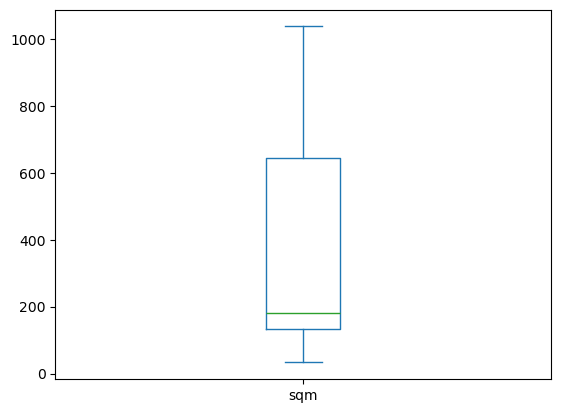

In [62]:
# checking sqm

df["sqm"].plot(kind="box")

# as seen we have some outlines

In [63]:
# chekcing sqm > 1000 as these are most likely incorrect

df[df["sqm"] > 1000]

,type_and_address,Købesum,m² & Kr. / m²,Vær.,%_change_between_offer_and_purchase,purchase_price,sqm,no_rooms,year_build,date,sales_type
21849,Villa VVilla Søndre Strandvej 28A 3000 Helsingør,14.500.000 kr.,1038 m² 13.969 kr/m²,14,NaN,14500000,1038.0,14,1930,2025-02-02,regular_sale


In [64]:
# dropping rows with sqm greater than 1000

df = df.drop(df[df["sqm"] > 1000].index)

In [65]:
# chekcing sqm less than or equal to 25 as these are most likely incorrect

df[df["sqm"] <= 25]

,type_and_address,Købesum,m² & Kr. / m²,Vær.,%_change_between_offer_and_purchase,purchase_price,sqm,no_rooms,year_build,date,sales_type


In [66]:
# dropping rows with sqm less than or equal to 25

df = df.drop(df[df["sqm"] <= 25].index)

In [67]:
# chekcng df

df.head(3)

,type_and_address,Købesum,m² & Kr. / m²,Vær.,%_change_between_offer_and_purchase,purchase_price,sqm,no_rooms,year_build,date,sales_type
0,Villa VVilla Nordlundsvej 43 2650 Hvidovre,6.375.000 kr.,180 m² 35.417 kr/m²,6,-2%,6375000,180.0,6,1954,2025-05-28,regular_sale
1,"Fritidshus FFritidshus Vikærparken 67, Diernæs...",1.200.000 kr.,74 m² 16.216 kr/m²,4,NaN,1200000,741.0,4,1993,2025-05-28,family_sale
2,"Rækkehus RRækkehus Vinterslevvej 53C, Vintersl...",2.775.000 kr.,112 m² 24.777 kr/m²,3,NaN,2775000,112.0,3,2022,2025-05-28,regular_sale


# 5. Split data and cleaning colums (%_change_between_offer_and_purchase column)

In [68]:
# deleting unwanted text in _change_between_offer_and_purchase column

df["%_change_between_offer_and_purchase"] = df["%_change_between_offer_and_purchase"].str.replace("%" , "")
df["%_change_between_offer_and_purchase"] = df["%_change_between_offer_and_purchase"].str.replace("." , "")

In [69]:
# convert to numeric column

df["%_change_between_offer_and_purchase"] = pd.to_numeric(df["%_change_between_offer_and_purchase"])

In [70]:
# convert from float64 to float32 to save memory

df["%_change_between_offer_and_purchase"] = df["%_change_between_offer_and_purchase"].astype(np.float32)

In [71]:
# checking value range in %_change_between_offer_and_purchase (ckecking for outlines)

df["%_change_between_offer_and_purchase"].value_counts(sort=True)

%_change_between_offer_and_purchase
-3.0      3862
-2.0      3341
-4.0      3196
-5.0      2627
-6.0      2075
          ... 
-51.0        1
 74.0        1
 79.0        1
-60.0        1
 686.0       1
Name: count, Length: 131, dtype: int64

<Axes: >

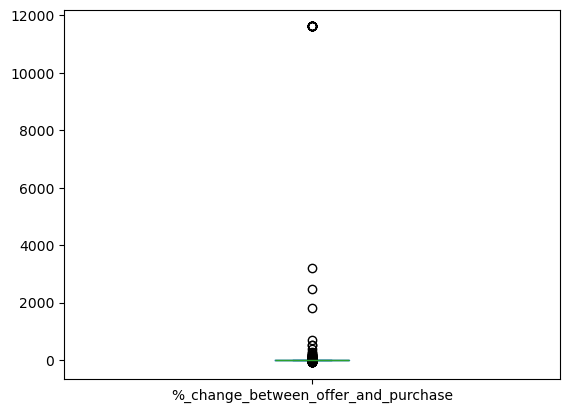

In [72]:
# plotting value range in %_change_between_offer_and_purchase (ckecking for outlines)

df["%_change_between_offer_and_purchase"].plot(kind="box")

In [73]:
# checking number of rows with change greater than 49%

df["%_change_between_offer_and_purchase"].loc[df["%_change_between_offer_and_purchase"] > 49]

5726      3194.0
7998        65.0
8054       266.0
8664       206.0
10589       83.0
10637       78.0
11226       88.0
12193       60.0
14134      111.0
16478     1811.0
17384       55.0
18296       67.0
24964       74.0
25572       79.0
27670      505.0
28442       56.0
28569       78.0
29665      240.0
31612      176.0
31715      167.0
31810      107.0
31983      176.0
32503       61.0
33440     2471.0
33926       51.0
33980       51.0
33992       51.0
34109       51.0
34193       51.0
34199       51.0
34690       88.0
34835       64.0
35068      366.0
36350      121.0
36374      121.0
38607    11620.0
38614    11620.0
38641    11620.0
38651    11620.0
38662    11620.0
38669    11620.0
38682    11620.0
38738    11620.0
38746    11620.0
38747    11620.0
38785       73.0
38810    11620.0
38857    11620.0
38898    11620.0
38913    11620.0
38939    11620.0
38952    11620.0
42351      116.0
43538      177.0
44340      531.0
44802      129.0
45511      686.0
Name: %_change_between_offer_an

In [74]:
# dropping rows with change ahove 49% (https://stackoverflow.com/questions/13851535/how-to-delete-rows-from-a-pandas-dataframe-based-on-a-conditional-expression)

df = df.drop(df[df["%_change_between_offer_and_purchase"] > 49].index)

In [75]:
# checking number of rows with change greater than -49%

df["%_change_between_offer_and_purchase"].loc[df["%_change_between_offer_and_purchase"] < -49]

508     -50.0
4166    -63.0
4700    -52.0
6801    -58.0
9028    -55.0
11408   -54.0
11895   -83.0
12230   -52.0
12375   -52.0
13616   -73.0
17131   -50.0
17816   -50.0
21044   -50.0
22338   -51.0
23276   -70.0
25496   -54.0
27031   -60.0
35469   -70.0
38495   -72.0
39281   -75.0
40550   -50.0
40770   -50.0
45133   -62.0
45191   -59.0
46798   -50.0
Name: %_change_between_offer_and_purchase, dtype: float32

In [76]:
# dropping rows with change greater than -49%

df = df.drop(df[df["%_change_between_offer_and_purchase"] < -49].index)

In [77]:
df.shape

(46819, 11)

In [78]:
# checking "buckets" of change

df["%_change_between_offer_and_purchase"].value_counts(bins=20)

(-5.7, -1.0]        15058
(-10.4, -5.7]        6389
(-15.1, -10.4]       1839
(-1.0, 3.7]          1681
(-19.8, -15.1]        573
(3.7, 8.4]            488
(-24.5, -19.8]        348
(-29.2, -24.5]        122
(8.4, 13.1]           111
(-33.9, -29.2]         63
(-38.6, -33.9]         57
(13.1, 17.8]           36
(-43.3, -38.6]         29
(17.8, 22.5]           18
(22.5, 27.2]           14
(-48.095, -43.3]       12
(27.2, 31.9]            3
(31.9, 36.6]            3
(36.6, 41.3]            3
(41.3, 46.0]            2
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

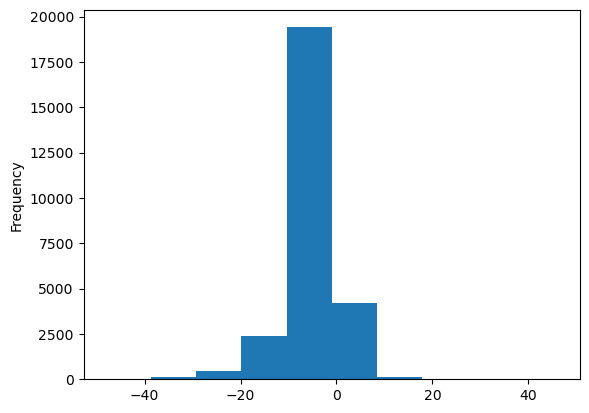

In [79]:
# visual checking "buckets" of change

df["%_change_between_offer_and_purchase"].plot(kind="hist")

In [80]:
# checking for NaNs in %_change_between_offer_and_purchase

df["%_change_between_offer_and_purchase"].isna().sum()

np.int64(19970)

In [81]:
# replaceing NaN with 0 as there was no difference better offer price and purchase price

df['%_change_between_offer_and_purchase'] = df['%_change_between_offer_and_purchase'].replace(np.nan, 0)


In [82]:
# checking buckets

df["%_change_between_offer_and_purchase"].value_counts(bins=20).sort_index()


(-48.095, -43.3]       12
(-43.3, -38.6]         29
(-38.6, -33.9]         57
(-33.9, -29.2]         63
(-29.2, -24.5]        122
(-24.5, -19.8]        348
(-19.8, -15.1]        573
(-15.1, -10.4]       1839
(-10.4, -5.7]        6389
(-5.7, -1.0]        15058
(-1.0, 3.7]         21651
(3.7, 8.4]            488
(8.4, 13.1]           111
(13.1, 17.8]           36
(17.8, 22.5]           18
(22.5, 27.2]           14
(27.2, 31.9]            3
(31.9, 36.6]            3
(36.6, 41.3]            3
(41.3, 46.0]            2
Name: count, dtype: int64

In [83]:
df.head(3)

,type_and_address,Købesum,m² & Kr. / m²,Vær.,%_change_between_offer_and_purchase,purchase_price,sqm,no_rooms,year_build,date,sales_type
0,Villa VVilla Nordlundsvej 43 2650 Hvidovre,6.375.000 kr.,180 m² 35.417 kr/m²,6,-2.0,6375000,180.0,6,1954,2025-05-28,regular_sale
1,"Fritidshus FFritidshus Vikærparken 67, Diernæs...",1.200.000 kr.,74 m² 16.216 kr/m²,4,0.0,1200000,741.0,4,1993,2025-05-28,family_sale
2,"Rækkehus RRækkehus Vinterslevvej 53C, Vintersl...",2.775.000 kr.,112 m² 24.777 kr/m²,3,0.0,2775000,112.0,3,2022,2025-05-28,regular_sale


# 6. Split data and cleaning colums (type_and_address column)

In [84]:
# spliting text to get an overview and creating a variable (var)

var = df["type_and_address"].str.split(" ", n=11, expand=True)

In [85]:
# checking var

var.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11
0,Villa,VVilla,Nordlundsvej,43,,2650,Hvidovre,None,None,None,None,None
1,Fritidshus,FFritidshus,Vikærparken,"67,",Diernæs,,6100,Haderslev,None,None,None,None
2,Rækkehus,RRækkehus,Vinterslevvej,"53C,",Vinterslev,,8370,Hadsten,None,None,None,None


In [86]:
# seeems like we have some double text

var[1].value_counts()

1
VVilla            22703
EEjerlejlighed    12193
FFritidshus        5530
RRækkehus          4339
LLandejendom       2054
Name: count, dtype: int64

In [87]:
# seeems like we have some double text (checking again)

df["type_and_address"]

0              Villa VVilla Nordlundsvej 43  2650 Hvidovre
1        Fritidshus FFritidshus Vikærparken 67, Diernæs...
2        Rækkehus RRækkehus Vinterslevvej 53C, Vintersl...
3        Fritidshus FFritidshus Carl Alstrupsvej 5  337...
4                     Villa VVilla Kærvej 36  9440 Aabybro
                               ...                        
48295    Ejerlejlighed EEjerlejlighed Vadgårdsvej 7, 1....
48296           Villa VVilla Borgergade 24  6752 Glejbjerg
48297               Villa VVilla Slårupvej 1  7160 Tørring
48298             Villa VVilla Middelvej 10  2820 Gentofte
48299    Ejerlejlighed EEjerlejlighed Langdraget 3, 1. ...
Name: type_and_address, Length: 46819, dtype: object

In [88]:
# deleting housing type "duplicates" in each string

df["type_and_address"] = df["type_and_address"].str.replace("VVilla " , "" )
df["type_and_address"] = df["type_and_address"].str.replace("EEjerlejlighed " , "" )
df["type_and_address"] = df["type_and_address"].str.replace("FFritidshus " , "" )
df["type_and_address"] = df["type_and_address"].str.replace("RRÃ¦kkehus " , "")
df["type_and_address"] = df["type_and_address"].str.replace("LLandejendom " , "" )
df["type_and_address"] = df["type_and_address"].str.replace("RRækkehus " , "" )

In [89]:
# checking cleaned data

var = df["type_and_address"].str.split(" ", n=9, expand=True)

In [90]:
# checking cleaned data

var[0].value_counts()

0
Villa            22703
Ejerlejlighed    12193
Fritidshus        5530
Rækkehus          4339
Landejendom       2054
Name: count, dtype: int64

In [91]:
# replacing DK text with ENG text

df["type_and_address"] = df["type_and_address"].str.replace("Villa " , "Villa " )
df["type_and_address"] = df["type_and_address"].str.replace("Ejerlejlighed " , "Apartment " )
df["type_and_address"] = df["type_and_address"].str.replace("Fritidshus " , "Summerhouse " )
df["type_and_address"] = df["type_and_address"].str.replace("RÃ¦kkehus " , "Townhouse ")
df["type_and_address"] = df["type_and_address"].str.replace("Landejendom " , "Farm " )
df["type_and_address"] = df["type_and_address"].str.replace("Rækkehus " , "Summerhouse " )

In [92]:
var

,0,1,2,3,4,5,6,7,8,9
0,Villa,Nordlundsvej,43,,2650,Hvidovre,None,None,None,None
1,Fritidshus,Vikærparken,"67,",Diernæs,,6100,Haderslev,None,None,None
2,Rækkehus,Vinterslevvej,"53C,",Vinterslev,,8370,Hadsten,None,None,None
3,Fritidshus,Carl,Alstrupsvej,5,,3370,Melby,None,None,None
4,Villa,Kærvej,36,,9440,Aabybro,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...
48295,Ejerlejlighed,Vadgårdsvej,"7,",1.,th,,2860,Søborg,None,None
48296,Villa,Borgergade,24,,6752,Glejbjerg,None,None,None,None
48297,Villa,Slårupvej,1,,7160,Tørring,None,None,None,None
48298,Villa,Middelvej,10,,2820,Gentofte,None,None,None,None


In [93]:
# we want split the column in order to create a new column called "house_type"

df["type_and_address"].str.split(" ", n=1, expand=True)

,0,1
0,Villa,Nordlundsvej 43 2650 Hvidovre
1,Summerhouse,"Vikærparken 67, Diernæs 6100 Haderslev"
2,Summerhouse,"Vinterslevvej 53C, Vinterslev 8370 Hadsten"
3,Summerhouse,Carl Alstrupsvej 5 3370 Melby
4,Villa,Kærvej 36 9440 Aabybro
...,...,...
48295,Apartment,"Vadgårdsvej 7, 1. th 2860 Søborg"
48296,Villa,Borgergade 24 6752 Glejbjerg
48297,Villa,Slårupvej 1 7160 Tørring
48298,Villa,Middelvej 10 2820 Gentofte


In [94]:
# creating new column with house_type

new_col = df["type_and_address"].str.split(" ", n=1, expand=True)
df["house_type"] = new_col[0]

In [95]:
# checking unique "strings"

df["house_type"].unique()

array(['Villa', 'Summerhouse', 'Apartment', 'Farm'], dtype=object)

In [96]:
# change from dtype object to category to save memory

df["house_type"] = df["house_type"].astype("category")

In [97]:
# deleting house_type text from "type_and_address" column

df["type_and_address"] = df["type_and_address"].str.replace("Villa " , "" )
df["type_and_address"] = df["type_and_address"].str.replace("Apartment " , "" )
df["type_and_address"] = df["type_and_address"].str.replace("Summerhouse " , "" )
df["type_and_address"] = df["type_and_address"].str.replace("Townhouse " ,  "")
df["type_and_address"] = df["type_and_address"].str.replace("Farm " , "")

In [99]:
# replacing odd charectars with DK letters

df["type_and_address"] = df["type_and_address"].str.replace("Ã¦" , "æ")
df["type_and_address"] = df["type_and_address"].str.replace("Ã¸" , "ø")
df["type_and_address"] = df["type_and_address"].str.replace("Ã¥" , "å")
df["type_and_address"] = df["type_and_address"].str.replace("Ã" , "A")
df["type_and_address"] = df["type_and_address"].str.replace("-Ã" , "A")

In [100]:
# checking type_and_address split as we want to seperate on address, zip code and city

df["type_and_address"].str.split(" ", n=8, expand=True)

,0,1,2,3,4,5,6,7,8
0,Nordlundsvej,43,,2650,Hvidovre,None,None,None,None
1,Vikærparken,"67,",Diernæs,,6100,Haderslev,None,None,None
2,Vinterslevvej,"53C,",Vinterslev,,8370,Hadsten,None,None,None
3,Carl,Alstrupsvej,5,,3370,Melby,None,None,None
4,Kærvej,36,,9440,Aabybro,None,None,None,None
...,...,...,...,...,...,...,...,...,...
48295,Vadgårdsvej,"7,",1.,th,,2860,Søborg,None,None
48296,Borgergade,24,,6752,Glejbjerg,None,None,None,None
48297,Slårupvej,1,,7160,Tørring,None,None,None,None
48298,Middelvej,10,,2820,Gentofte,None,None,None,None


In [101]:
# checking names list

names = df["type_and_address"].tolist()

In [102]:
#names

In [103]:
# we can split on double space thus...:

df["type_and_address"].str.split("  ", n=2, expand=True)

,0,1
0,Nordlundsvej 43,2650 Hvidovre
1,"Vikærparken 67, Diernæs",6100 Haderslev
2,"Vinterslevvej 53C, Vinterslev",8370 Hadsten
3,Carl Alstrupsvej 5,3370 Melby
4,Kærvej 36,9440 Aabybro
...,...,...
48295,"Vadgårdsvej 7, 1. th",2860 Søborg
48296,Borgergade 24,6752 Glejbjerg
48297,Slårupvej 1,7160 Tørring
48298,Middelvej 10,2820 Gentofte


In [104]:
# creating new 2 columns for adress and zip code and city

new_cols = new_col = df["type_and_address"].str.split("  ", n=2, expand=True)
df["address"] = new_cols[0]
df["city_test"] = new_cols[1]

In [105]:
# creating new column for zip_code

df["zip_code"] = df["city_test"].str[0:4]

In [106]:
# convert to numeric column

df["zip_code"] = pd.to_numeric(df["zip_code"])

In [107]:
df["zip_code"].info()

<class 'pandas.core.series.Series'>
Index: 46819 entries, 0 to 48299
Series name: zip_code
Non-Null Count  Dtype
--------------  -----
46819 non-null  int64
dtypes: int64(1)
memory usage: 731.5 KB


In [108]:
df["zip_code"] = df["zip_code"].astype(np.int16)

In [109]:
# creating new column for city

df["city"] = df["city_test"].str[5:]

In [110]:
# dropping columns we do not need any longer

df = df.drop(['type_and_address', 'city_test'], axis=1)

In [111]:
# checking df

df.head(3)

,Købesum,m² & Kr. / m²,Vær.,%_change_between_offer_and_purchase,purchase_price,sqm,no_rooms,year_build,date,sales_type,house_type,address,zip_code,city
0,6.375.000 kr.,180 m² 35.417 kr/m²,6,-2.0,6375000,180.0,6,1954,2025-05-28,regular_sale,Villa,Nordlundsvej 43,2650,Hvidovre
1,1.200.000 kr.,74 m² 16.216 kr/m²,4,0.0,1200000,741.0,4,1993,2025-05-28,family_sale,Summerhouse,"Vikærparken 67, Diernæs",6100,Haderslev
2,2.775.000 kr.,112 m² 24.777 kr/m²,3,0.0,2775000,112.0,3,2022,2025-05-28,regular_sale,Summerhouse,"Vinterslevvej 53C, Vinterslev",8370,Hadsten


# 7. Split data and cleaning colums (no_rooms column)

<Axes: >

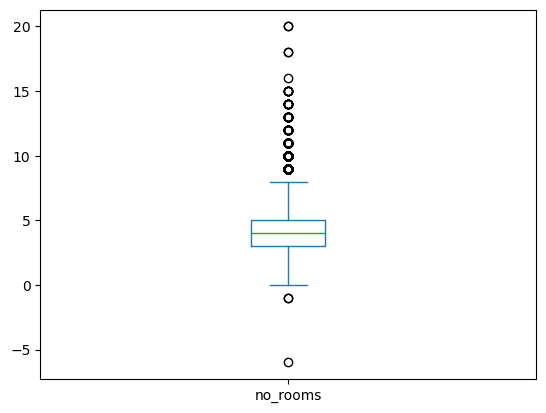

In [112]:
# checking no_romms

df["no_rooms"].plot(kind="box")

# we have outliers and want to delete those

In [113]:
# chekcing no_rooms > 15

df[df["no_rooms"] > 15]

,Købesum,m² & Kr. / m²,Vær.,%_change_between_offer_and_purchase,purchase_price,sqm,no_rooms,year_build,date,sales_type,house_type,address,zip_code,city
320,30.765.000 kr.,240 m² 128.188 kr/m²,20,0.0,30765000,240.0,20,1800,2025-05-20,family_sale,Farm,Marienlyst 1,4760,Vordingborg
13361,1.750.000 kr.,878 m² 1.993 kr/m²,18,0.0,1750000,878.0,18,1561,2025-03-05,regular_sale,Farm,Hastrupvej 3D,4720,Præstø
18325,20.978.500 kr.,578 m² 33.836 kr/m²,20,0.0,20978500,578.0,20,1840,2025-02-15,family_sale,Farm,"Brogesvej 6, Løjstrup",8870,Langå
34743,48.500.000 kr.,411 m² 118.005 kr/m²,16,0.0,48500000,411.0,16,1599,2024-12-10,regular_sale,Villa,"Maria Hjerte Engen 4B, Gjerrild",8500,Grenaa
42271,785.436 kr.,528 m² 1.488 kr/m²,18,0.0,785436,528.0,18,1929,2024-11-14,other_sale,Farm,"Rørholtvej 32, Ulsted",9370,Hals


In [114]:
# dropping rows with no_rooms greater than 15

df = df.drop(df[df["no_rooms"] > 15].index)

In [115]:
df[df["no_rooms"] < 1]

,Købesum,m² & Kr. / m²,Vær.,%_change_between_offer_and_purchase,purchase_price,sqm,no_rooms,year_build,date,sales_type,house_type,address,zip_code,city
182,2.300.000 kr.,0 m² kr/m²,0,0.0,2300000,NaN,0,0,2025-05-22,regular_sale,Villa,"Krigsagervej 1K, Søborg",3250,Gilleleje
3206,2.898.000 kr.,130 m² 22.292 kr/m²,0,0.0,2898000,130.0,0,1972,2025-04-22,regular_sale,Villa,Solbrinken 36,8300,Odder
8653,1.545.000 kr.,224 m² kr/m²,0,0.0,1545000,224.0,0,1929,2025-03-24,regular_sale,Apartment,"Nygade 1C, 1. 3",4900,Nakskov
9285,8.700.000 kr.,135 m² kr/m²,-1,0.0,8700000,135.0,-1,1900,2025-03-20,regular_sale,Apartment,"Algade 70D, 1. tv",4760,Vordingborg
10586,609.000 kr.,131 m² kr/m²,0,0.0,609000,131.0,0,1975,2025-03-16,regular_sale,Villa,Gammel Rimsøvej 23,8585,Glesborg
11431,500.000 kr.,0 m² kr/m²,0,0.0,500000,NaN,0,0,2025-03-12,regular_sale,Summerhouse,"Vejlby Klit 6A, Vejlby",7673,Harboøre
20834,1.681.673 kr.,0 m² kr/m²,0,0.0,1681673,NaN,0,2025,2025-02-05,regular_sale,Villa,Mulden 48,4330,Hvalsø
23344,8.500.000 kr.,253 m² kr/m²,-1,0.0,8500000,253.0,-1,1878,2025-01-27,regular_sale,Apartment,"Lavendelstræde 17D, 2.",1462,København K
23423,1.950.000 kr.,0 m² kr/m²,0,0.0,1950000,NaN,0,0,2025-01-27,regular_sale,Summerhouse,Sundeved 6,9700,Brønderslev
28582,400.000 kr.,0 m² kr/m²,0,0.0,400000,NaN,0,0,2025-01-07,regular_sale,Summerhouse,"Pragtstjernevej 22, Tørring",7620,Lemvig


In [116]:
# dropping rows with no_rooms less than 1

df = df.drop(df[df["no_rooms"] < 1].index)

In [117]:
# change dtype

df["no_rooms"] = df["no_rooms"].astype("int8")

# 8. Split data and cleaning colums (year_build column)

<Axes: >

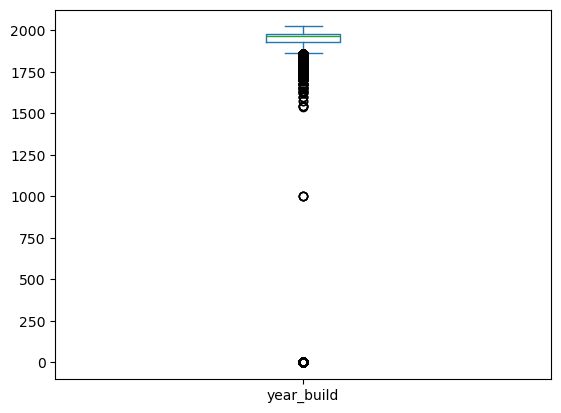

In [118]:
# checking for outlines in year build

df["year_build"].plot(kind="box")

In [119]:
# chekcing year_build less than 1000

df[df["year_build"] < 1000]

,Købesum,m² & Kr. / m²,Vær.,%_change_between_offer_and_purchase,purchase_price,sqm,no_rooms,year_build,date,sales_type,house_type,address,zip_code,city
385,725.000 kr.,151 m² 3.059 kr/m²,5,-3.0,725000,151.0,5,0,2025-05-19,regular_sale,Villa,"Frisholmparken 138, Them",8653,Them
1092,4.058.720 kr.,450 m² 9.019 kr/m²,10,0.0,4058720,450.0,10,0,2025-05-07,regular_sale,Farm,"Fjordvejen 89, Sønderhav",6340,Kruså
1669,1.995.000 kr.,120 m² 16.625 kr/m²,4,0.0,1995000,120.0,4,0,2025-05-01,regular_sale,Summerhouse,Peder Oxesvej 4,3300,Frederiksværk
2467,3.675.000 kr.,57 m² 64.474 kr/m²,2,-3.0,3675000,576.0,2,0,2025-04-27,regular_sale,Apartment,"Amager Strandvej 58F, 3. 3",2300,København S
2557,725.000 kr.,217 m² 3.341 kr/m²,4,0.0,725000,217.0,4,0,2025-04-27,regular_sale,Villa,Krabbesgade 17,8620,Kjellerup
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47486,658.400 kr.,80 m² 8.230 kr/m²,4,0.0,658400,808.0,4,0,2024-10-28,family_sale,Summerhouse,"Frede Juels Vej 278, Sønderby",7130,Juelsminde
47687,850.000 kr.,182 m² 4.670 kr/m²,6,0.0,850000,182.0,6,0,2024-10-27,regular_sale,Villa,"Ane Jacobsens Vej 9, Gauerslund",7080,Børkop
47788,2.795.000 kr.,98 m² 28.520 kr/m²,3,0.0,2795000,982.0,3,0,2024-10-27,regular_sale,Summerhouse,Skovgården 16,4330,Hvalsø
47945,691.997 kr.,183 m² 3.781 kr/m²,4,0.0,691997,183.0,4,0,2024-10-27,regular_sale,Villa,"Bagervej 1, Vester Sottrup",6400,Sønderborg


In [120]:
# dropping rows with year_build less than 1000

df = df.drop(df[df["year_build"] < 1000].index)

In [121]:
# convert to int16

df["year_build"] = df["year_build"].astype("int16")

# 9. Further checks and finetuning

In [122]:
# create a new column call sqm_price

df["sqm_price"] = df["purchase_price"] / df["sqm"]

In [123]:
# converting dtype to save memory

df["sqm_price"] = df["sqm_price"].astype("float32")

<Axes: >

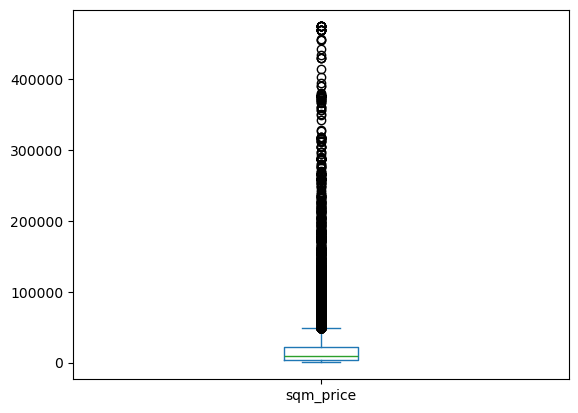

In [124]:
df["sqm_price"].plot(kind="box")

In [125]:
# checking for outlines

df[df["sqm_price"] > 75_000]

,Købesum,m² & Kr. / m²,Vær.,%_change_between_offer_and_purchase,purchase_price,sqm,no_rooms,year_build,date,sales_type,house_type,address,zip_code,city,sqm_price
77,10.900.000 kr.,145 m² 75.172 kr/m²,4,0.0,10900000,145.0,4,1934,2025-05-26,regular_sale,Apartment,"Blidahpark 29, 1. tv",2900,Hellerup,75172.414062
90,10.000.000 kr.,120 m² 83.333 kr/m²,4,-9.0,10000000,120.0,4,1931,2025-05-25,regular_sale,Villa,Italiensvej 72,2300,København S,83333.335938
169,11.300.000 kr.,139 m² 81.295 kr/m²,5,0.0,11300000,139.0,5,1878,2025-05-22,regular_sale,Farm,Kimmerslevvej 7,4140,Borup,81294.960938
173,24.775.000 kr.,148 m² 167.399 kr/m²,6,0.0,24775000,148.0,6,1924,2025-05-22,other_sale,Apartment,"Kildegårdsvej 1B, st. tv, Øster Stillinge",4200,Slagelse,167398.656250
193,24.775.000 kr.,289 m² 85.727 kr/m²,7,0.0,24775000,289.0,7,1984,2025-05-22,other_sale,Farm,"Kildegårdsvej 1, Øster Stillinge",4200,Slagelse,85726.640625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48078,17.998.125 kr.,120 m² 149.984 kr/m²,4,0.0,17998125,120.0,4,1936,2024-10-26,other_sale,Farm,"Lundevej 20, Skads",6705,Esbjerg Ø,149984.375000
48086,21.995.000 kr.,235 m² 93.596 kr/m²,4,0.0,21995000,235.0,4,2023,2024-10-26,regular_sale,Apartment,"Dunkerquegade 10, 3. tv",2150,Nordhavn,93595.742188
48137,8.750.000 kr.,106 m² 82.547 kr/m²,5,-3.0,8750000,106.0,5,2019,2024-10-26,regular_sale,Apartment,"Thorvald Bindesbølls Plads 18, st. tv",1799,København V,82547.171875
48197,12.697.400 kr.,144 m² 88.176 kr/m²,5,0.0,12697400,144.0,5,1970,2024-10-25,regular_sale,Farm,"Bøstrupvej 70, Bøstrup",7840,Højslev,88176.390625


In [126]:
# dropping rows with sqm_price greater than than DKK 75000

df = df.drop(df[df["sqm_price"] > 75000].index)

In [127]:
df.head(3)

,Købesum,m² & Kr. / m²,Vær.,%_change_between_offer_and_purchase,purchase_price,sqm,no_rooms,year_build,date,sales_type,house_type,address,zip_code,city,sqm_price
0,6.375.000 kr.,180 m² 35.417 kr/m²,6,-2.0,6375000,180.0,6,1954,2025-05-28,regular_sale,Villa,Nordlundsvej 43,2650,Hvidovre,35416.667969
1,1.200.000 kr.,74 m² 16.216 kr/m²,4,0.0,1200000,741.0,4,1993,2025-05-28,family_sale,Summerhouse,"Vikærparken 67, Diernæs",6100,Haderslev,1619.433228
2,2.775.000 kr.,112 m² 24.777 kr/m²,3,0.0,2775000,112.0,3,2022,2025-05-28,regular_sale,Summerhouse,"Vinterslevvej 53C, Vinterslev",8370,Hadsten,24776.785156


In [128]:
# checkng dtypes

df.dtypes

Købesum                                        object
m² & Kr. / m²                                  object
Vær.                                            int64
%_change_between_offer_and_purchase           float32
purchase_price                                  int32
sqm                                           float32
no_rooms                                         int8
year_build                                      int16
date                                   datetime64[ns]
sales_type                                   category
house_type                                   category
address                                        object
zip_code                                        int16
city                                           object
sqm_price                                     float32
dtype: object

In [129]:
# adding a quater column 

df["quarter"] = pd.PeriodIndex(df["date"], freq="Q")

In [130]:
# adding an unique house_id

df["house_id"] = df.groupby(['address', 'zip_code'], sort = False).ngroup()

In [131]:
# reordering columns

neworder = ['date', 'quarter', 'house_id', 'house_type', 'sales_type', 'year_build', 'purchase_price', '%_change_between_offer_and_purchase' , 'no_rooms', 'sqm', 'sqm_price', 'address', 'zip_code' , 'city']

df=df.reindex(columns=neworder)

In [132]:
df.head(5)

,date,quarter,house_id,house_type,sales_type,year_build,purchase_price,%_change_between_offer_and_purchase,no_rooms,sqm,sqm_price,address,zip_code,city
0,2025-05-28,2025Q2,0,Villa,regular_sale,1954,6375000,-2.0,6,180.0,35416.667969,Nordlundsvej 43,2650,Hvidovre
1,2025-05-28,2025Q2,1,Summerhouse,family_sale,1993,1200000,0.0,4,741.0,1619.433228,"Vikærparken 67, Diernæs",6100,Haderslev
2,2025-05-28,2025Q2,2,Summerhouse,regular_sale,2022,2775000,0.0,3,112.0,24776.785156,"Vinterslevvej 53C, Vinterslev",8370,Hadsten
3,2025-05-28,2025Q2,3,Summerhouse,family_sale,1974,900000,0.0,3,581.0,1549.053345,Carl Alstrupsvej 5,3370,Melby
4,2025-05-28,2025Q2,4,Villa,regular_sale,1961,1100000,-12.0,3,921.0,1194.354004,Kærvej 36,9440,Aabybro


In [133]:
df.columns

Index(['date', 'quarter', 'house_id', 'house_type', 'sales_type', 'year_build',
       'purchase_price', '%_change_between_offer_and_purchase', 'no_rooms',
       'sqm', 'sqm_price', 'address', 'zip_code', 'city'],
      dtype='object')

In [134]:
df.shape

(45486, 14)

In [135]:
# checking for duplicates with same sales date

df[df.duplicated(["address", "zip_code", "date" ], keep=False)]

,date,quarter,house_id,house_type,sales_type,year_build,purchase_price,%_change_between_offer_and_purchase,no_rooms,sqm,sqm_price,address,zip_code,city


In [136]:
# duplicates with same sales date i.e. only one row

df = df.drop_duplicates(subset=['address', 'zip_code', 'date'], keep='first')

In [137]:
df.shape

(45486, 14)

In [138]:
df["house_id"] = df.groupby(['address', 'zip_code'], sort = False).ngroup()

In [139]:
df

,date,quarter,house_id,house_type,sales_type,year_build,purchase_price,%_change_between_offer_and_purchase,no_rooms,sqm,sqm_price,address,zip_code,city
0,2025-05-28,2025Q2,0,Villa,regular_sale,1954,6375000,-2.0,6,180.0,35416.667969,Nordlundsvej 43,2650,Hvidovre
1,2025-05-28,2025Q2,1,Summerhouse,family_sale,1993,1200000,0.0,4,741.0,1619.433228,"Vikærparken 67, Diernæs",6100,Haderslev
2,2025-05-28,2025Q2,2,Summerhouse,regular_sale,2022,2775000,0.0,3,112.0,24776.785156,"Vinterslevvej 53C, Vinterslev",8370,Hadsten
3,2025-05-28,2025Q2,3,Summerhouse,family_sale,1974,900000,0.0,3,581.0,1549.053345,Carl Alstrupsvej 5,3370,Melby
4,2025-05-28,2025Q2,4,Villa,regular_sale,1961,1100000,-12.0,3,921.0,1194.354004,Kærvej 36,9440,Aabybro
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48295,2024-10-25,2024Q4,45478,Apartment,regular_sale,1946,2300000,-4.0,3,603.0,3814.261963,"Vadgårdsvej 7, 1. th",2860,Søborg
48296,2024-10-25,2024Q4,45479,Villa,regular_sale,1956,450000,0.0,4,895.0,502.793304,Borgergade 24,6752,Glejbjerg
48297,2024-10-25,2024Q4,45480,Villa,regular_sale,1966,2495000,0.0,6,187.0,13342.246094,Slårupvej 1,7160,Tørring
48298,2024-10-25,2024Q4,45481,Villa,regular_sale,1950,7550000,-3.0,5,120.0,62916.667969,Middelvej 10,2820,Gentofte


In [140]:
df[df.duplicated('house_id', keep=False)]

,date,quarter,house_id,house_type,sales_type,year_build,purchase_price,%_change_between_offer_and_purchase,no_rooms,sqm,sqm_price,address,zip_code,city
11517,2025-03-12,2025Q1,10901,Summerhouse,regular_sale,1978,980000,-2.0,4,100.0,9800.0,Ingeborgvej 2,9480,Løkken
20723,2025-02-05,2025Q1,10901,Summerhouse,regular_sale,1978,715000,-4.0,4,100.0,7150.0,Ingeborgvej 2,9480,Løkken
37960,2024-11-28,2024Q4,10901,Summerhouse,regular_sale,1978,815000,-1.0,4,100.0,8150.0,Ingeborgvej 2,9480,Løkken
43375,2024-11-11,2024Q4,10901,Summerhouse,regular_sale,1978,900000,-5.0,4,100.0,9000.0,Ingeborgvej 2,9480,Løkken


In [141]:
df.loc[df['house_id'] == 77891]

,date,quarter,house_id,house_type,sales_type,year_build,purchase_price,%_change_between_offer_and_purchase,no_rooms,sqm,sqm_price,address,zip_code,city


In [142]:
###https://www.geeksforgeeks.org/delete-duplicates-in-a-pandas-dataframe-based-on-two-columns/

In [143]:
df.sort_values(by=['house_id', 'date'])

,date,quarter,house_id,house_type,sales_type,year_build,purchase_price,%_change_between_offer_and_purchase,no_rooms,sqm,sqm_price,address,zip_code,city
0,2025-05-28,2025Q2,0,Villa,regular_sale,1954,6375000,-2.0,6,180.0,35416.667969,Nordlundsvej 43,2650,Hvidovre
1,2025-05-28,2025Q2,1,Summerhouse,family_sale,1993,1200000,0.0,4,741.0,1619.433228,"Vikærparken 67, Diernæs",6100,Haderslev
2,2025-05-28,2025Q2,2,Summerhouse,regular_sale,2022,2775000,0.0,3,112.0,24776.785156,"Vinterslevvej 53C, Vinterslev",8370,Hadsten
3,2025-05-28,2025Q2,3,Summerhouse,family_sale,1974,900000,0.0,3,581.0,1549.053345,Carl Alstrupsvej 5,3370,Melby
4,2025-05-28,2025Q2,4,Villa,regular_sale,1961,1100000,-12.0,3,921.0,1194.354004,Kærvej 36,9440,Aabybro
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48295,2024-10-25,2024Q4,45478,Apartment,regular_sale,1946,2300000,-4.0,3,603.0,3814.261963,"Vadgårdsvej 7, 1. th",2860,Søborg
48296,2024-10-25,2024Q4,45479,Villa,regular_sale,1956,450000,0.0,4,895.0,502.793304,Borgergade 24,6752,Glejbjerg
48297,2024-10-25,2024Q4,45480,Villa,regular_sale,1966,2495000,0.0,6,187.0,13342.246094,Slårupvej 1,7160,Tørring
48298,2024-10-25,2024Q4,45481,Villa,regular_sale,1950,7550000,-3.0,5,120.0,62916.667969,Middelvej 10,2820,Gentofte


In [144]:
df['date_diff'] = df.groupby('house_id')['date'].diff().dt.days

In [145]:
df['date_diff'].isna().sum()

np.int64(45483)

In [146]:
df_cleaned = df[df['date_diff'].isna() | (df['date_diff'] >= 14)]

In [147]:
df = df_cleaned.drop(columns=['date_diff'])

In [148]:
df

,date,quarter,house_id,house_type,sales_type,year_build,purchase_price,%_change_between_offer_and_purchase,no_rooms,sqm,sqm_price,address,zip_code,city
0,2025-05-28,2025Q2,0,Villa,regular_sale,1954,6375000,-2.0,6,180.0,35416.667969,Nordlundsvej 43,2650,Hvidovre
1,2025-05-28,2025Q2,1,Summerhouse,family_sale,1993,1200000,0.0,4,741.0,1619.433228,"Vikærparken 67, Diernæs",6100,Haderslev
2,2025-05-28,2025Q2,2,Summerhouse,regular_sale,2022,2775000,0.0,3,112.0,24776.785156,"Vinterslevvej 53C, Vinterslev",8370,Hadsten
3,2025-05-28,2025Q2,3,Summerhouse,family_sale,1974,900000,0.0,3,581.0,1549.053345,Carl Alstrupsvej 5,3370,Melby
4,2025-05-28,2025Q2,4,Villa,regular_sale,1961,1100000,-12.0,3,921.0,1194.354004,Kærvej 36,9440,Aabybro
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48295,2024-10-25,2024Q4,45478,Apartment,regular_sale,1946,2300000,-4.0,3,603.0,3814.261963,"Vadgårdsvej 7, 1. th",2860,Søborg
48296,2024-10-25,2024Q4,45479,Villa,regular_sale,1956,450000,0.0,4,895.0,502.793304,Borgergade 24,6752,Glejbjerg
48297,2024-10-25,2024Q4,45480,Villa,regular_sale,1966,2495000,0.0,6,187.0,13342.246094,Slårupvej 1,7160,Tørring
48298,2024-10-25,2024Q4,45481,Villa,regular_sale,1950,7550000,-3.0,5,120.0,62916.667969,Middelvej 10,2820,Gentofte


# 10. Importing zip code data file

In [153]:
zd = pd.read_excel(r'Addtional_data/DK_regions_zip_codes.xlsx')

In [154]:
zd.dtypes

zip_code     int64
area        object
region      object
dtype: object

In [155]:
# changing dtype to save memory

zd["area"] = zd["area"].astype("category")
zd["region"] = zd["region"].astype("category")

In [156]:
df.shape

(45483, 14)

In [157]:

# Define a function to assign the region_name and region_no based on zip_code

# OBS! SLOW code however couldn't get dirc. version to work

def assign_region(row):
    if 0 <= row['zip_code'] <= 999:
        return pd.Series(['Special for organisation and large corportes', 'Non given'], index=['area', 'region'])
    elif 1000 <= row['zip_code'] <= 2999:
        return pd.Series(['Capital, Copenhagen', 'Zealand'], index=['area', 'region'])
    elif 3000 <= row['zip_code'] <= 3699:
        return pd.Series(['North Zealand', 'Zealand'], index=['area', 'region'])
    elif 3700 <= row['zip_code'] <= 3799:
        return pd.Series(['Bornholm', 'Bornholm'], index=['area', 'region'])
    elif 3800 <= row['zip_code'] <= 3899:
        return pd.Series(['Faroe Islands', 'Faroe Islands'], index=['area', 'region'])
    elif 3900 <= row['zip_code'] <= 3999:
        return pd.Series(['Greenland', 'Greenland'], index=['area', 'region'])
    elif 4000 <= row['zip_code'] <= 4999:
        return pd.Series(['Other islands', 'Zealand'], index=['area', 'region'])
    elif 5000 <= row['zip_code'] <= 5999:
        return pd.Series(['Fyn & islands', 'Fyn & islands'], index=['area', 'region'])
    elif 6000 <= row['zip_code'] <= 6999:
        return pd.Series(['South jutland', 'Jutland'], index=['area', 'region'])
    elif 7000 <= row['zip_code'] <= 7999:
        return pd.Series(['South jutland', 'Jutland'], index=['area', 'region'])
    elif 8000 <= row['zip_code'] <= 8999:
        return pd.Series(['East & mid jutland', 'Jutland'], index=['area', 'region'])
    elif 9000 <= row['zip_code'] <= 9999:
        return pd.Series(['North jutland', 'Jutland'], index=['area', 'region'])
    else:
        return pd.Series([None, None], index=['region_name', 'region_no'])

# Apply the function to the DataFrame
df[['area', 'region']] = df.apply(assign_region, axis=1)

In [158]:
df.shape

(45483, 16)

In [159]:
df["region"].unique()

array(['Zealand', 'Jutland', 'Bornholm', 'Fyn & islands'], dtype=object)

In [160]:
df

,date,quarter,house_id,house_type,sales_type,year_build,purchase_price,%_change_between_offer_and_purchase,no_rooms,sqm,sqm_price,address,zip_code,city,area,region
0,2025-05-28,2025Q2,0,Villa,regular_sale,1954,6375000,-2.0,6,180.0,35416.667969,Nordlundsvej 43,2650,Hvidovre,"Capital, Copenhagen",Zealand
1,2025-05-28,2025Q2,1,Summerhouse,family_sale,1993,1200000,0.0,4,741.0,1619.433228,"Vikærparken 67, Diernæs",6100,Haderslev,South jutland,Jutland
2,2025-05-28,2025Q2,2,Summerhouse,regular_sale,2022,2775000,0.0,3,112.0,24776.785156,"Vinterslevvej 53C, Vinterslev",8370,Hadsten,East & mid jutland,Jutland
3,2025-05-28,2025Q2,3,Summerhouse,family_sale,1974,900000,0.0,3,581.0,1549.053345,Carl Alstrupsvej 5,3370,Melby,North Zealand,Zealand
4,2025-05-28,2025Q2,4,Villa,regular_sale,1961,1100000,-12.0,3,921.0,1194.354004,Kærvej 36,9440,Aabybro,North jutland,Jutland
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48295,2024-10-25,2024Q4,45478,Apartment,regular_sale,1946,2300000,-4.0,3,603.0,3814.261963,"Vadgårdsvej 7, 1. th",2860,Søborg,"Capital, Copenhagen",Zealand
48296,2024-10-25,2024Q4,45479,Villa,regular_sale,1956,450000,0.0,4,895.0,502.793304,Borgergade 24,6752,Glejbjerg,South jutland,Jutland
48297,2024-10-25,2024Q4,45480,Villa,regular_sale,1966,2495000,0.0,6,187.0,13342.246094,Slårupvej 1,7160,Tørring,South jutland,Jutland
48298,2024-10-25,2024Q4,45481,Villa,regular_sale,1950,7550000,-3.0,5,120.0,62916.667969,Middelvej 10,2820,Gentofte,"Capital, Copenhagen",Zealand


# 11. Importing interest rate data file

In [162]:
ird = pd.read_excel(r'Addtional_data/DK_interest_rates.xlsx')

In [163]:
# replacing in order to convert to data format

ird["date"] = ird["date"].str.replace("M" , "-" )
ird["date"] = ird["date"].str.replace("D" , "-" )

In [164]:
# date convert

ird["date"] = pd.to_datetime(ird["date"], dayfirst=False)


In [165]:
ird["quarter"] = pd.PeriodIndex(ird["date"], freq="Q")

In [166]:
ird = ird.drop('date', axis=1)

In [167]:
ird["quarter"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 8233 entries, 0 to 8232
Series name: quarter
Non-Null Count  Dtype        
--------------  -----        
8233 non-null   period[Q-DEC]
dtypes: period[Q-DEC](1)
memory usage: 64.4 KB


In [168]:
ird.dtypes

nom_interest_rate%          float64
quarter               period[Q-DEC]
dtype: object

In [169]:
ird

,nom_interest_rate%,quarter
0,9.50,1992Q1
1,9.50,1992Q1
2,9.50,1992Q1
3,9.50,1992Q1
4,9.50,1992Q1
...,...,...
8228,2.85,2024Q4
8229,2.85,2024Q4
8230,2.85,2024Q4
8231,2.85,2024Q4


In [170]:
#ird.sort_index(ascending=False)

In [171]:
# Ensure there are no duplicates in 'ird' for the 'quarter' column
ird_unique = ird.drop_duplicates(subset='quarter')

# Now, perform the merge
df = df.merge(ird_unique[['quarter', 'nom_interest_rate%']], on='quarter', how='left')

In [172]:
df

,date,quarter,house_id,house_type,sales_type,year_build,purchase_price,%_change_between_offer_and_purchase,no_rooms,sqm,sqm_price,address,zip_code,city,area,region,nom_interest_rate%
0,2025-05-28,2025Q2,0,Villa,regular_sale,1954,6375000,-2.0,6,180.0,35416.667969,Nordlundsvej 43,2650,Hvidovre,"Capital, Copenhagen",Zealand,NaN
1,2025-05-28,2025Q2,1,Summerhouse,family_sale,1993,1200000,0.0,4,741.0,1619.433228,"Vikærparken 67, Diernæs",6100,Haderslev,South jutland,Jutland,NaN
2,2025-05-28,2025Q2,2,Summerhouse,regular_sale,2022,2775000,0.0,3,112.0,24776.785156,"Vinterslevvej 53C, Vinterslev",8370,Hadsten,East & mid jutland,Jutland,NaN
3,2025-05-28,2025Q2,3,Summerhouse,family_sale,1974,900000,0.0,3,581.0,1549.053345,Carl Alstrupsvej 5,3370,Melby,North Zealand,Zealand,NaN
4,2025-05-28,2025Q2,4,Villa,regular_sale,1961,1100000,-12.0,3,921.0,1194.354004,Kærvej 36,9440,Aabybro,North jutland,Jutland,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45478,2024-10-25,2024Q4,45478,Apartment,regular_sale,1946,2300000,-4.0,3,603.0,3814.261963,"Vadgårdsvej 7, 1. th",2860,Søborg,"Capital, Copenhagen",Zealand,3.1
45479,2024-10-25,2024Q4,45479,Villa,regular_sale,1956,450000,0.0,4,895.0,502.793304,Borgergade 24,6752,Glejbjerg,South jutland,Jutland,3.1
45480,2024-10-25,2024Q4,45480,Villa,regular_sale,1966,2495000,0.0,6,187.0,13342.246094,Slårupvej 1,7160,Tørring,South jutland,Jutland,3.1
45481,2024-10-25,2024Q4,45481,Villa,regular_sale,1950,7550000,-3.0,5,120.0,62916.667969,Middelvej 10,2820,Gentofte,"Capital, Copenhagen",Zealand,3.1


# 12. Importing inflation rate data file

In [179]:
inflation = pd.read_excel(r'Addtional_data/DK_inflation_rates.xlsx')

In [180]:
inflation.head(3)

,date,dk_ann_infl_rate%
0,2024-09-30,1.13 %
1,2024-06-30,1.13 %
2,2024-03-31,1.13 %


In [181]:
inflation["dk_ann_infl_rate%"] = inflation["dk_ann_infl_rate%"].str.replace(" %" , "" )
inflation["dk_ann_infl_rate%"] = pd.to_numeric(inflation["dk_ann_infl_rate%"])

In [182]:
inflation["quarter"] = pd.PeriodIndex(inflation["date"], freq="Q")

In [183]:
inflation.head(3)

,date,dk_ann_infl_rate%,quarter
0,2024-09-30,1.13,2024Q3
1,2024-06-30,1.13,2024Q2
2,2024-03-31,1.13,2024Q1


In [184]:
inflation.drop("date", axis=1)

,dk_ann_infl_rate%,quarter
0,1.13,2024Q3
1,1.13,2024Q2
2,1.13,2024Q1
3,3.31,2023Q4
4,3.31,2023Q3
...,...,...
126,1.26,1993Q1
127,2.10,1992Q4
128,2.10,1992Q3
129,2.10,1992Q2


In [185]:
# Ensure there are no duplicates in 'ird' for the 'quarter' column
inflation_unique = inflation.drop_duplicates(subset='quarter')

# Now, perform the merge
df = df.merge(inflation_unique[['quarter', 'dk_ann_infl_rate%']], on='quarter', how='left')

In [186]:
df.head(3)

,date,quarter,house_id,house_type,sales_type,year_build,purchase_price,%_change_between_offer_and_purchase,no_rooms,sqm,sqm_price,address,zip_code,city,area,region,nom_interest_rate%,dk_ann_infl_rate%
0,2025-05-28,2025Q2,0,Villa,regular_sale,1954,6375000,-2.0,6,180.0,35416.667969,Nordlundsvej 43,2650,Hvidovre,"Capital, Copenhagen",Zealand,NaN,NaN
1,2025-05-28,2025Q2,1,Summerhouse,family_sale,1993,1200000,0.0,4,741.0,1619.433228,"Vikærparken 67, Diernæs",6100,Haderslev,South jutland,Jutland,NaN,NaN
2,2025-05-28,2025Q2,2,Summerhouse,regular_sale,2022,2775000,0.0,3,112.0,24776.785156,"Vinterslevvej 53C, Vinterslev",8370,Hadsten,East & mid jutland,Jutland,NaN,NaN


In [187]:
inflation_unique

,date,dk_ann_infl_rate%,quarter
0,2024-09-30,1.13,2024Q3
1,2024-06-30,1.13,2024Q2
2,2024-03-31,1.13,2024Q1
3,2023-12-31,3.31,2023Q4
4,2023-09-30,3.31,2023Q3
...,...,...,...
126,1993-03-31,1.26,1993Q1
127,1992-12-31,2.10,1992Q4
128,1992-09-30,2.10,1992Q3
129,1992-06-30,2.10,1992Q2


In [188]:
df.loc[df["quarter"] == '2024Q3']

,date,quarter,house_id,house_type,sales_type,year_build,purchase_price,%_change_between_offer_and_purchase,no_rooms,sqm,sqm_price,address,zip_code,city,area,region,nom_interest_rate%,dk_ann_infl_rate%


In [189]:
df["dk_ann_infl_rate%"].isna().sum()

np.int64(45483)

# 13. Importing inflation rate data file

In [191]:
morgage = pd.read_excel(r'Addtional_data/DK_morgage_rates.xlsx')

In [192]:
morgage.head(3)

,date,yield_on_mortgage_credit_bonds%
0,1992-03-30,10.14
1,1992-06-30,10.14
2,1992-09-30,10.14


In [193]:
morgage.dtypes

date                               datetime64[ns]
yield_on_mortgage_credit_bonds%           float64
dtype: object

In [194]:
morgage["quarter"] = pd.PeriodIndex(morgage["date"], freq="Q")

In [195]:
morgage.head(3)

,date,yield_on_mortgage_credit_bonds%,quarter
0,1992-03-30,10.14,1992Q1
1,1992-06-30,10.14,1992Q2
2,1992-09-30,10.14,1992Q3


In [196]:
morgage.drop("date", axis=1)

,yield_on_mortgage_credit_bonds%,quarter
0,10.14,1992Q1
1,10.14,1992Q2
2,10.14,1992Q3
3,10.14,1992Q4
4,8.16,1993Q1
...,...,...
126,4.79,2023Q3
127,4.79,2023Q4
128,4.34,2024Q1
129,4.34,2024Q2


In [197]:
morgage_unique = morgage.drop_duplicates(subset='quarter')

# Now, perform the merge
df = df.merge(morgage_unique[['quarter', 'yield_on_mortgage_credit_bonds%']], on='quarter', how='left')

In [198]:
df.head()

,date,quarter,house_id,house_type,sales_type,year_build,purchase_price,%_change_between_offer_and_purchase,no_rooms,sqm,sqm_price,address,zip_code,city,area,region,nom_interest_rate%,dk_ann_infl_rate%,yield_on_mortgage_credit_bonds%
0,2025-05-28,2025Q2,0,Villa,regular_sale,1954,6375000,-2.0,6,180.0,35416.667969,Nordlundsvej 43,2650,Hvidovre,"Capital, Copenhagen",Zealand,NaN,NaN,NaN
1,2025-05-28,2025Q2,1,Summerhouse,family_sale,1993,1200000,0.0,4,741.0,1619.433228,"Vikærparken 67, Diernæs",6100,Haderslev,South jutland,Jutland,NaN,NaN,NaN
2,2025-05-28,2025Q2,2,Summerhouse,regular_sale,2022,2775000,0.0,3,112.0,24776.785156,"Vinterslevvej 53C, Vinterslev",8370,Hadsten,East & mid jutland,Jutland,NaN,NaN,NaN
3,2025-05-28,2025Q2,3,Summerhouse,family_sale,1974,900000,0.0,3,581.0,1549.053345,Carl Alstrupsvej 5,3370,Melby,North Zealand,Zealand,NaN,NaN,NaN
4,2025-05-28,2025Q2,4,Villa,regular_sale,1961,1100000,-12.0,3,921.0,1194.354004,Kærvej 36,9440,Aabybro,North jutland,Jutland,NaN,NaN,NaN


In [199]:
df.loc[df["quarter"] == '2024Q3']

,date,quarter,house_id,house_type,sales_type,year_build,purchase_price,%_change_between_offer_and_purchase,no_rooms,sqm,sqm_price,address,zip_code,city,area,region,nom_interest_rate%,dk_ann_infl_rate%,yield_on_mortgage_credit_bonds%


In [200]:
df.loc[df["quarter"] == '1995Q3']

,date,quarter,house_id,house_type,sales_type,year_build,purchase_price,%_change_between_offer_and_purchase,no_rooms,sqm,sqm_price,address,zip_code,city,area,region,nom_interest_rate%,dk_ann_infl_rate%,yield_on_mortgage_credit_bonds%


In [201]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45483 entries, 0 to 45482
Data columns (total 19 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   date                                 45483 non-null  datetime64[ns]
 1   quarter                              45483 non-null  period[Q-DEC] 
 2   house_id                             45483 non-null  int64         
 3   house_type                           45483 non-null  category      
 4   sales_type                           45483 non-null  category      
 5   year_build                           45483 non-null  int16         
 6   purchase_price                       45483 non-null  int32         
 7   %_change_between_offer_and_purchase  45483 non-null  float32       
 8   no_rooms                             45483 non-null  int8          
 9   sqm                                  45483 non-null  float32       
 10  sqm_price 

# 14. Final checks and adjustments

In [202]:
df["nom_interest_rate%"] = df["nom_interest_rate%"].astype("float32")
df["dk_ann_infl_rate%"] = df["dk_ann_infl_rate%"].astype("float32")
df["yield_on_mortgage_credit_bonds%"] = df["yield_on_mortgage_credit_bonds%"].astype("float32")

In [203]:
df["area"] = df["area"].astype("category")
df["region"] = df["region"].astype("category")

In [204]:
df

,date,quarter,house_id,house_type,sales_type,year_build,purchase_price,%_change_between_offer_and_purchase,no_rooms,sqm,sqm_price,address,zip_code,city,area,region,nom_interest_rate%,dk_ann_infl_rate%,yield_on_mortgage_credit_bonds%
0,2025-05-28,2025Q2,0,Villa,regular_sale,1954,6375000,-2.0,6,180.0,35416.667969,Nordlundsvej 43,2650,Hvidovre,"Capital, Copenhagen",Zealand,NaN,NaN,NaN
1,2025-05-28,2025Q2,1,Summerhouse,family_sale,1993,1200000,0.0,4,741.0,1619.433228,"Vikærparken 67, Diernæs",6100,Haderslev,South jutland,Jutland,NaN,NaN,NaN
2,2025-05-28,2025Q2,2,Summerhouse,regular_sale,2022,2775000,0.0,3,112.0,24776.785156,"Vinterslevvej 53C, Vinterslev",8370,Hadsten,East & mid jutland,Jutland,NaN,NaN,NaN
3,2025-05-28,2025Q2,3,Summerhouse,family_sale,1974,900000,0.0,3,581.0,1549.053345,Carl Alstrupsvej 5,3370,Melby,North Zealand,Zealand,NaN,NaN,NaN
4,2025-05-28,2025Q2,4,Villa,regular_sale,1961,1100000,-12.0,3,921.0,1194.354004,Kærvej 36,9440,Aabybro,North jutland,Jutland,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45478,2024-10-25,2024Q4,45478,Apartment,regular_sale,1946,2300000,-4.0,3,603.0,3814.261963,"Vadgårdsvej 7, 1. th",2860,Søborg,"Capital, Copenhagen",Zealand,3.1,NaN,NaN
45479,2024-10-25,2024Q4,45479,Villa,regular_sale,1956,450000,0.0,4,895.0,502.793304,Borgergade 24,6752,Glejbjerg,South jutland,Jutland,3.1,NaN,NaN
45480,2024-10-25,2024Q4,45480,Villa,regular_sale,1966,2495000,0.0,6,187.0,13342.246094,Slårupvej 1,7160,Tørring,South jutland,Jutland,3.1,NaN,NaN
45481,2024-10-25,2024Q4,45481,Villa,regular_sale,1950,7550000,-3.0,5,120.0,62916.667969,Middelvej 10,2820,Gentofte,"Capital, Copenhagen",Zealand,3.1,NaN,NaN


In [205]:
df = df.sort_values(by=['date'], ascending=False)

In [206]:
df

,date,quarter,house_id,house_type,sales_type,year_build,purchase_price,%_change_between_offer_and_purchase,no_rooms,sqm,sqm_price,address,zip_code,city,area,region,nom_interest_rate%,dk_ann_infl_rate%,yield_on_mortgage_credit_bonds%
0,2025-05-28,2025Q2,0,Villa,regular_sale,1954,6375000,-2.0,6,180.0,35416.667969,Nordlundsvej 43,2650,Hvidovre,"Capital, Copenhagen",Zealand,NaN,NaN,NaN
2,2025-05-28,2025Q2,2,Summerhouse,regular_sale,2022,2775000,0.0,3,112.0,24776.785156,"Vinterslevvej 53C, Vinterslev",8370,Hadsten,East & mid jutland,Jutland,NaN,NaN,NaN
3,2025-05-28,2025Q2,3,Summerhouse,family_sale,1974,900000,0.0,3,581.0,1549.053345,Carl Alstrupsvej 5,3370,Melby,North Zealand,Zealand,NaN,NaN,NaN
4,2025-05-28,2025Q2,4,Villa,regular_sale,1961,1100000,-12.0,3,921.0,1194.354004,Kærvej 36,9440,Aabybro,North jutland,Jutland,NaN,NaN,NaN
1,2025-05-28,2025Q2,1,Summerhouse,family_sale,1993,1200000,0.0,4,741.0,1619.433228,"Vikærparken 67, Diernæs",6100,Haderslev,South jutland,Jutland,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45409,2024-10-25,2024Q4,45409,Villa,regular_sale,1957,2200000,-12.0,5,161.0,13664.596680,Solbakken 54,8450,Hammel,East & mid jutland,Jutland,3.1,NaN,NaN
45408,2024-10-25,2024Q4,45408,Summerhouse,regular_sale,1877,1100000,-15.0,3,681.0,1615.271606,Sct Hansgade 7,5600,Faaborg,Fyn & islands,Fyn & islands,3.1,NaN,NaN
45407,2024-10-25,2024Q4,45407,Villa,regular_sale,2019,6350000,-2.0,4,172.0,36918.605469,Lindevej 46,2630,Taastrup,"Capital, Copenhagen",Zealand,3.1,NaN,NaN
45406,2024-10-25,2024Q4,45406,Villa,regular_sale,1950,1520000,-2.0,2,841.0,1807.372192,Norgesvej 5,4700,Næstved,Other islands,Zealand,3.1,NaN,NaN


# 15. Exporting

In [207]:
# 15. Export cleaned master file
df.to_csv('master.csv', index=False)
print("Wrote cleaned master.csv with", len(df), "rows")

Wrote cleaned master.csv with 45483 rows


In [219]:
from pathlib import Path

# 1. define the path
parquet_path = Path.cwd() / "par.parquet"

# 2. write out
df.to_parquet(
    parquet_path,
    engine="pyarrow",
    compression="snappy",
    index=False
)
print(f"Wrote parquet file to {parquet_path}")

# 3. sanity check that the file exists
if not parquet_path.exists():
    raise FileNotFoundError(f"{parquet_path} not found!")

# 4. read back in
df_t = pd.read_parquet(parquet_path, engine="pyarrow")
df_t.info()

Wrote parquet file to /Users/victor/School/sem6/bachelor/scraping/par.parquet
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45483 entries, 0 to 45482
Data columns (total 19 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   date                                 45483 non-null  datetime64[ns]
 1   quarter                              45483 non-null  period[Q-DEC] 
 2   house_id                             45483 non-null  int64         
 3   house_type                           45483 non-null  category      
 4   sales_type                           45483 non-null  category      
 5   year_build                           45483 non-null  int16         
 6   purchase_price                       45483 non-null  int32         
 7   %_change_between_offer_and_purchase  45483 non-null  float32       
 8   no_rooms                             45483 non-null  int8          
 9   sqm  

In [212]:
df_t

,date,quarter,house_id,house_type,sales_type,year_build,purchase_price,%_change_between_offer_and_purchase,no_rooms,sqm,sqm_price,address,zip_code,city,area,region,nom_interest_rate%,dk_ann_infl_rate%,yield_on_mortgage_credit_bonds%
0,2025-05-28,2025Q2,0,Villa,regular_sale,1954,6375000,-2.0,6,180.0,35416.667969,Nordlundsvej 43,2650,Hvidovre,"Capital, Copenhagen",Zealand,NaN,NaN,NaN
1,2025-05-28,2025Q2,2,Summerhouse,regular_sale,2022,2775000,0.0,3,112.0,24776.785156,"Vinterslevvej 53C, Vinterslev",8370,Hadsten,East & mid jutland,Jutland,NaN,NaN,NaN
2,2025-05-28,2025Q2,3,Summerhouse,family_sale,1974,900000,0.0,3,581.0,1549.053345,Carl Alstrupsvej 5,3370,Melby,North Zealand,Zealand,NaN,NaN,NaN
3,2025-05-28,2025Q2,4,Villa,regular_sale,1961,1100000,-12.0,3,921.0,1194.354004,Kærvej 36,9440,Aabybro,North jutland,Jutland,NaN,NaN,NaN
4,2025-05-28,2025Q2,1,Summerhouse,family_sale,1993,1200000,0.0,4,741.0,1619.433228,"Vikærparken 67, Diernæs",6100,Haderslev,South jutland,Jutland,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45478,2024-10-25,2024Q4,45409,Villa,regular_sale,1957,2200000,-12.0,5,161.0,13664.596680,Solbakken 54,8450,Hammel,East & mid jutland,Jutland,3.1,NaN,NaN
45479,2024-10-25,2024Q4,45408,Summerhouse,regular_sale,1877,1100000,-15.0,3,681.0,1615.271606,Sct Hansgade 7,5600,Faaborg,Fyn & islands,Fyn & islands,3.1,NaN,NaN
45480,2024-10-25,2024Q4,45407,Villa,regular_sale,2019,6350000,-2.0,4,172.0,36918.605469,Lindevej 46,2630,Taastrup,"Capital, Copenhagen",Zealand,3.1,NaN,NaN
45481,2024-10-25,2024Q4,45406,Villa,regular_sale,1950,1520000,-2.0,2,841.0,1807.372192,Norgesvej 5,4700,Næstved,Other islands,Zealand,3.1,NaN,NaN


In [214]:
df_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45483 entries, 0 to 45482
Data columns (total 19 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   date                                 45483 non-null  datetime64[ns]
 1   quarter                              45483 non-null  period[Q-DEC] 
 2   house_id                             45483 non-null  int64         
 3   house_type                           45483 non-null  category      
 4   sales_type                           45483 non-null  category      
 5   year_build                           45483 non-null  int16         
 6   purchase_price                       45483 non-null  int32         
 7   %_change_between_offer_and_purchase  45483 non-null  float32       
 8   no_rooms                             45483 non-null  int8          
 9   sqm                                  45483 non-null  float32       
 10  sqm_price 

# 16. Extra for spliting parquet in two files